In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# lokasi data
data_dir = 'D:\KULIAH\BANGKIT 2022\CAPSTONE\Dataset\dataset_capstone_9'

In [3]:
# lihat jumlah file
total_dir = len(os.listdir(data_dir))
total_files = 0

for dirname, _, filenames in os.walk(data_dir):
    print('counting:', dirname)
    files_counter = 0
    for file in filenames:
        files_counter += 1
    total_files += files_counter
    print('total files in dir:', files_counter)

print('--------')
print('total number of files',total_files)
print('total number of directories',total_dir)

counting: D:\KULIAH\BANGKIT 2022\CAPSTONE\Dataset\dataset_capstone_9
total files in dir: 0
counting: D:\KULIAH\BANGKIT 2022\CAPSTONE\Dataset\dataset_capstone_9\kaca
total files in dir: 1000
counting: D:\KULIAH\BANGKIT 2022\CAPSTONE\Dataset\dataset_capstone_9\kardus
total files in dir: 1000
counting: D:\KULIAH\BANGKIT 2022\CAPSTONE\Dataset\dataset_capstone_9\kertas
total files in dir: 1008
counting: D:\KULIAH\BANGKIT 2022\CAPSTONE\Dataset\dataset_capstone_9\logam
total files in dir: 1006
counting: D:\KULIAH\BANGKIT 2022\CAPSTONE\Dataset\dataset_capstone_9\plastik
total files in dir: 1000
counting: D:\KULIAH\BANGKIT 2022\CAPSTONE\Dataset\dataset_capstone_9\trash
total files in dir: 1000
--------
total number of files 6014
total number of directories 6


In [4]:
# buat dataset untuk training dan validasi
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=100
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=100
)

Found 6014 files belonging to 6 classes.
Using 4812 files for training.
Found 6014 files belonging to 6 classes.
Using 1202 files for validation.


In [5]:
# lihat nama kelas
class_names = train_ds.class_names
print(class_names)

['kaca', 'kardus', 'kertas', 'logam', 'plastik', 'trash']


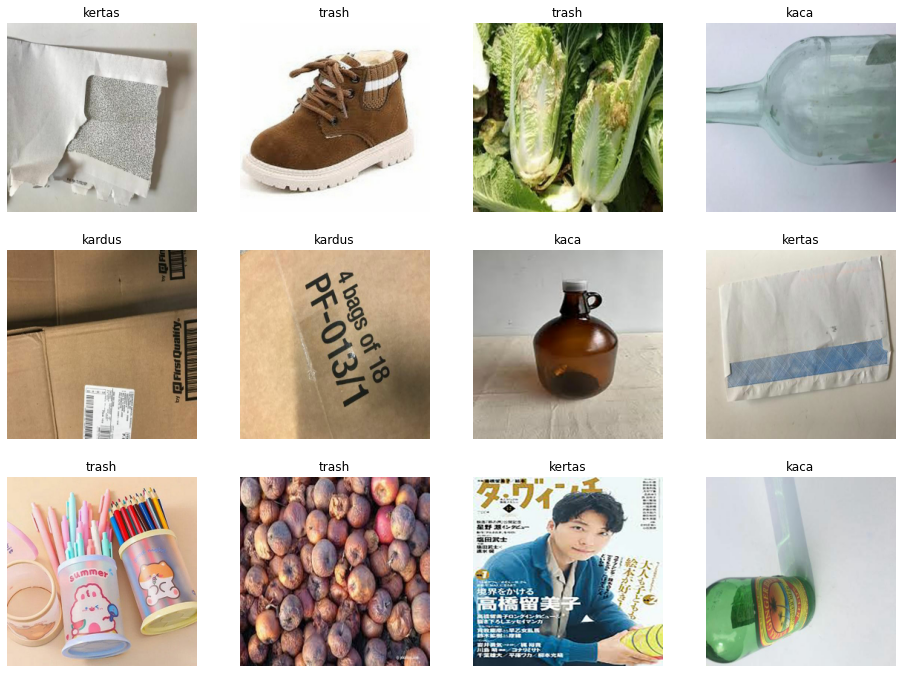

In [6]:
# lihat beberapa gambar dari train_ds
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

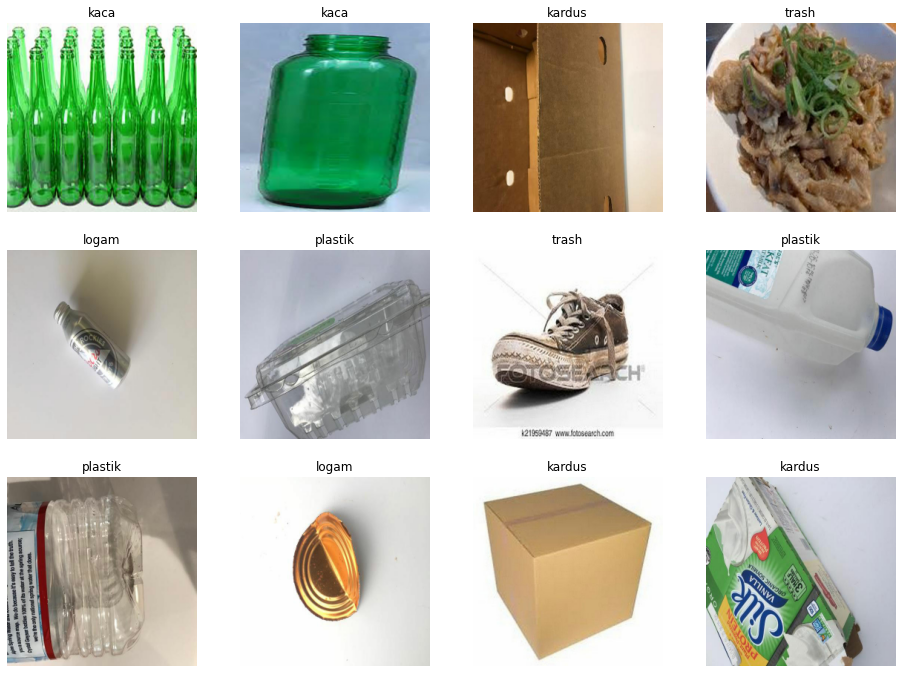

In [7]:
# lihat beberapa gambar dari validation_ds
plt.figure(figsize=(16, 16))
for images, labels in validation_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
# inspect train_ds
train_batch = train_ds.as_numpy_iterator().next()

print('total of batches:',len(train_ds))
print('images batch shape:',train_batch[0].shape)
print('labels batch shape:',train_batch[1].shape)

total of batches: 151
images batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


In [9]:
# inspect validation_ds
validation_batch = validation_ds.as_numpy_iterator().next()

print('total of batches:',len(validation_ds))
print('images batch shape:',validation_batch[0].shape)
print('labels batch shape:',validation_batch[1].shape)

total of batches: 38
images batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


In [10]:
# base model
input_shape = (256,256,3)
base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=input_shape)

# layer model trainable untuk tunning
base_model.trainable = True

In [11]:
# arsitektur model
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [12]:
print("Number of layers in the base model: {}".format(len(base_model.layers)))

Number of layers in the base model: 190


In [13]:
# tuning layer dan indeksnya
tuning_layer_name = 'conv5_block1_preact_bn'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)

# tuning
fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [14]:
# augmentasi
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1), 
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
], name='data_augmentation')

In [15]:
# arsitektur neural network
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(6, activation='softmax')
])

learning_rate = 0.00001
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['accuracy']
)

In [16]:
# train model
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

Epoch 1/10
151/151 [==============================] - 746s 5s/step - loss: 1.2815 - accuracy: 0.5378 - val_loss: 0.7363 - val_accuracy: 0.7546
Epoch 2/10
151/151 [==============================] - 657s 4s/step - loss: 0.6681 - accuracy: 0.7891 - val_loss: 0.4776 - val_accuracy: 0.8478
Epoch 3/10
151/151 [==============================] - 744s 5s/step - loss: 0.4915 - accuracy: 0.8477 - val_loss: 0.3735 - val_accuracy: 0.8810
Epoch 4/10
151/151 [==============================] - 629s 4s/step - loss: 0.3891 - accuracy: 0.8774 - val_loss: 0.3206 - val_accuracy: 0.8935
Epoch 5/10
151/151 [==============================] - 822s 5s/step - loss: 0.3257 - accuracy: 0.8982 - val_loss: 0.2800 - val_accuracy: 0.9068
Epoch 6/10
151/151 [==============================] - 793s 5s/step - loss: 0.2943 - accuracy: 0.9108 - val_loss: 0.2482 - val_accuracy: 0.9168
Epoch 7/10
151/151 [==============================] - 619s 4s/step - loss: 0.2493 - accuracy: 0.9179 - val_loss: 0.2287 - val_accuracy: 0.9201

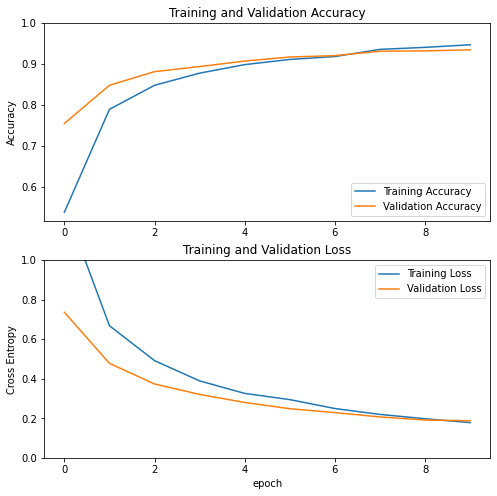

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
# performa model
loss, accuracy = model.evaluate(validation_ds)
print('Test accuracy :', accuracy)
print('Test loss:', loss)

38/38 [==============================] - 91s 2s/step - loss: 0.1874 - accuracy: 0.9343
Test accuracy : 0.9342762231826782
Test loss: 0.18735164403915405


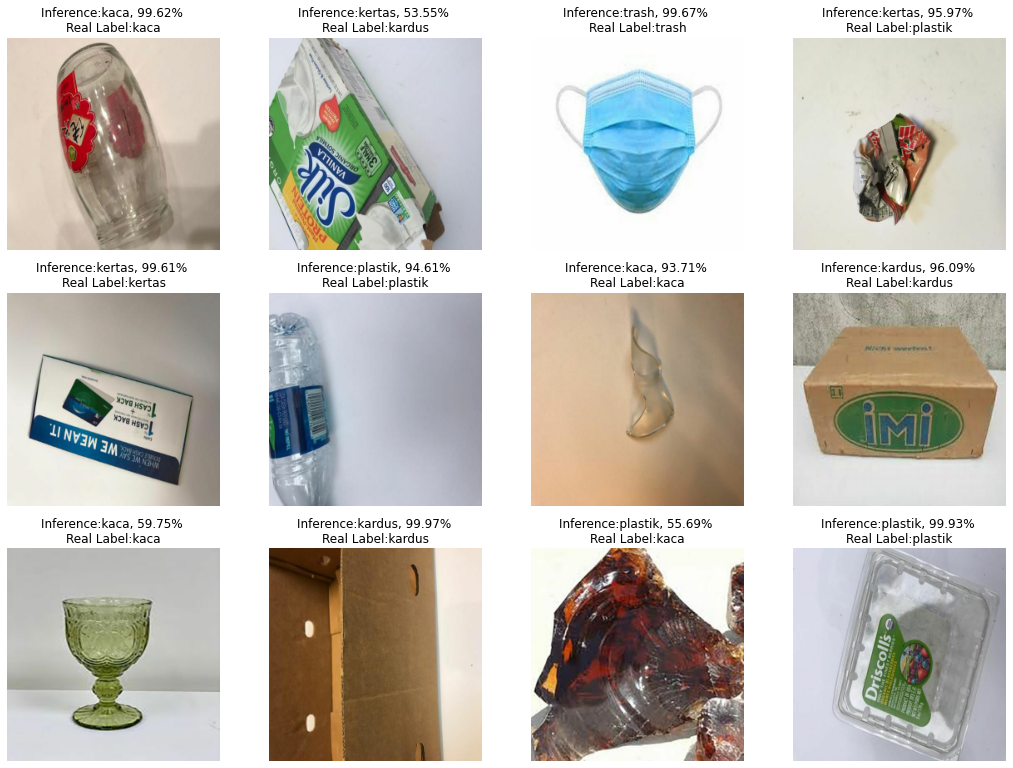

In [19]:
# predict dari dataset
image_batch, label_batch = validation_ds.as_numpy_iterator().next()

inference = model.predict_on_batch(image_batch)

plt.figure(figsize=(18, 18))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title('Inference:{}, {:.2f}% \nReal Label:{}'
              .format(class_names[np.argmax(inference[i])], 100 * np.max(inference[i]), class_names[label_batch[i]]))
    plt.axis("off")

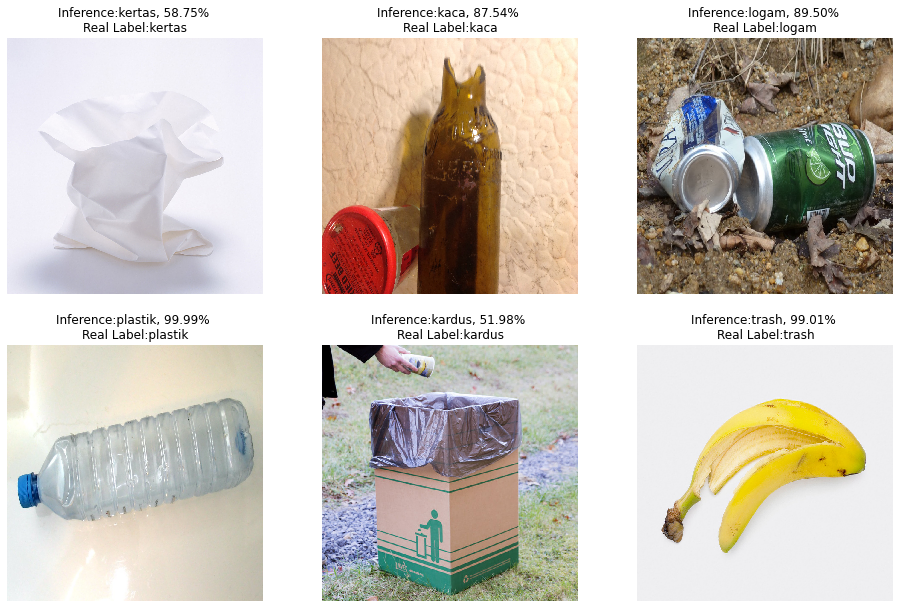

In [20]:
# inference dari luar
test_urls = [
    'https://uploads.ifdesign.de/award_img_121/oex_large/31983_01_4078_basket.jpg',
    'https://www.antique-bottles.net/attachments/image-jpg.201847/',
    'https://inzanetimes.files.wordpress.com/2013/04/canterbury41313016.jpg',
    'https://live.staticflickr.com/66/167934943_f61a850d96_b.jpg',
    'https://cdnimg.webstaurantstore.com/images/products/large/407128/1501927.jpg',
    'https://dy6g3i6a1660s.cloudfront.net/6n3yAQDV3zPhUIdvbTC-uwPUAoo/orig.jpg'
]
test_labels = [2, 0, 3, 4, 1, 5]

test_ds = []
image_size = (256, 256)
for i in range(len(test_urls)):
    path = tf.keras.utils.get_file(str(i), origin=test_urls[i])
    img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
    test_ds.append(tf.keras.preprocessing.image.img_to_array(img))
test_ds = np.array(test_ds)

# inference
test_inference = model.predict_on_batch(test_ds)


plt.figure(figsize=(16, 16))
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_ds[i].astype("uint8"))
    plt.title('Inference:{}, {:.2f}% \nReal Label:{}'
              .format(class_names[np.argmax(test_inference[i])], 100 * np.max(test_inference[i]), class_names[test_labels[i]]))
    plt.axis("off")

In [21]:
model.save('model_3.h5') 

C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [24]:
import pathlib

export_dir = 'D:\KULIAH\BANGKIT 2022\CAPSTONE\MODEL_3'

tf.saved_model.save(model, export_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./model_3.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: D:\KULIAH\BANGKIT 2022\CAPSTONE\MODEL_3\assets


24284048

In [25]:
tf.saved_model.save(model, 'D:\KULIAH\BANGKIT 2022\CAPSTONE\MODEL_3')

INFO:tensorflow:Assets written to: D:\KULIAH\BANGKIT 2022\CAPSTONE\MODEL_3\assets
